### Anly 580 Final Report

# How Can Topic Modeling Retrieve Information from Academic Research Papers, and Assign the Right Labels of Topic?

### Student group members and which student is responsible for what parts?
+ Data cleaning and preprocessing: Shiqi Ning (sn661)

+ Exploratory data analysis: Wen Li (wl565)

+ LDA Model: Xi Yang (xy140)

+ LSI Model: Jianing Sun (js4770)

### Motivation

+ Our research question is 'How can topic modeling retrieve information from academic research papers, and assign the right labels of topic?'

+ With the rapid accumulation of various scientific articles which are available online, machine learning methods such as topic modeling have been receiving much attention in those professional fields because of their interpretability. 

+ By analyzing “How Can Topic Modeling Retrieve Information from Academic Research Papers, and Assign the Right Labels of Topic?”, we can better identify the topic classification that are trending research topics in different academic realm in an efficient way.

### Relevant background research

Most of the work on the scientific research analysis implements with citations [1]. This method includes discovering the citation frequency, patterns and graphs to establish graphs between words and researchers. 

Another method to the academic research analysis depends on topic models. Topic modeling methods discover the hidden similarity between documents throughout the collection and annotate the documents content. The most popular topic model is Latent Dirichlet Allocation (LDA).	

Michael Paul and Roxana Girju implemented various novel topic models including LDA to classify research papers based on topic and language. They successfully gave various insightful statistics and correlations within and across three research fields: Linguistics, Computational Linguistics, and Education and showed a number of trends in each field along with relationships between topics, temporal correlations and topic influences across fields, as well as language trends. [2] 

Akira Murakami, Paul Thompson, Susan Hunston implemented Latent Dirichlet allocation (LDA) to automatically identifies “topics” in a given corpus. [3] They built model with 40, 50, 60, …, 100 topics and found 60 topics was the right level of granularity. In addition, they successfully built dynamic topic models that account for chronological change of keywords with topics.

### Data (collection) 
+ Dataset is collected using Springer Nature API, an API that allows developers to access 13 million freely available online content published by Springer.
+ Mathematics is chosen as the topic for query.
+ 10000 abstracts and titles from academic articles, papers, and book chapters are obtained from query.
+ Raw query dataset is JSON format.
+ Following codes are used to query the abstracts and titles

In [ ]:
# Import neede packages
import requests
import pandas as pd
import tqdm

# Define apikey and base 
apikey = 'df78856d424d8eba5d4b18ef9d70d0d8'
url_base = 'http://api.springernature.com/meta/v2/json'

# Set number of query and number of records each query
n_query = 100
n_eve_query = 100

# Initialize the dataframe and counter
df_raw = pd.DataFrame(columns=['doi', 'title', 'abstract'])
counter = 0

# Run specified number of iterations
for i in tqdm.tqdm(range(n_query)):
    # Set post url
    url_post = {'q': {'subject:Mathematics'},
                'p': n_eve_query,
                's': i*n_query + 1,
                'api_key':apikey
                }

    # Get response and convert to json
    response=requests.get(url_base, params = url_post)
    jsontxt = response.json()

    # Get records
    records = jsontxt['records']

    # Run through every record during the query
    for rec in records:
        # Get title, doi, and abstract
        title = rec['title']
        doi = rec['doi']
        abstract = rec['abstract']

        # Store the record into the data frame
        df_raw.loc[counter, 'title'] = title
        df_raw.loc[counter, 'doi'] = doi
        df_raw.loc[counter, 'abstract'] = abstract

        # Update counter
        counter += 1

# Save the dataframe to csv file
with open('df_abstract.csv','w', encoding="utf-8-sig", newline='') as output:
    df_raw.to_csv(output, sep=',',index = True, encoding='utf-8-sig')

# Check the shape of the raw data frame
print(df_raw.shape)

### Methods
**Latent Dirichlet Allocation (LDA)**
+ Created dictionary and corpus with Gensim.
+ Trained LDA model with LdaMulticore and traditional LDA.
+ Analyzed topics found by LDA model and generated new stop words for better results.
+ Generated weighted topics.

**Latent Semantic Indexing (LSI)**
+ Generate a document-term matrix of shape having TF-IDF scores using sklearn.
+ Reduce the dimensions of the matrix to k (no. of desired topics) dimensions, using singular-value decomposition (SVD).
+ Analyze topics found by LSI and do more data-preprocessing (add stop words, lemmatization, tokenization) 

**Important packages and tools**
+ Natural language related: regex, nltk, genism and sklearn.
+ Plotting related: matplotlib, bokeh, wordcloud, and seaborn.
+ Data related: requests, pandas, numpy, 


In [2]:
# Import libraries
import pandas as pd
import numpy as np

import nltk
#nltk.download('punkt') # wordpunct_tokenize
#nltk.download('averaged_perceptron_tagger') # tagged words

from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

# Preprocessing data
from nltk.corpus import stopwords

# Count word type
from nltk.probability import ConditionalFreqDist
from nltk.probability import FreqDist

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
import re
import nltk

from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
from gensim import models

import matplotlib.colors as mcolors

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from collections import Counter

from matplotlib.patches import Rectangle

### Procedure
**Data Cleaning**
+ Query results with empty abstracts are cleaned.
+ Abstracts written in languages other than English are cleaned out (9766 abstracts are left).
+ Content written in latex, latex math equations, and latex symbols (contents between single or double dollar signs) are cleaned out.
+ Single character, number, and special signs are cleaned out using regular expression.
+ Following codes are used to preprocess the data.

In [3]:
with open('df_abstract.csv', 'r', encoding="utf-8-sig") as abstract_data:
        df_raw = pd.read_csv(abstract_data , sep=',', index_col = False, header = 0, encoding="utf-8-sig")
    
    
df_raw = df_raw.loc[: , ['title', 'abstract']]

df_raw.dropna(axis = 0, inplace = True)

df_short = df_raw[:10000]

**Data Processing**
+ Words in the abstracts are then tokenized and lemmatized.
+ Stop words in English, as well as customized stop words for mathematics are cleaned out.
+ Bigram and trigram of the abstracts’ words are added.

In [4]:
def preprocessing(dataset):
    
    text_list = list(dataset['abstract'])
    
    # Stop words
    add_stop = ['solution', 'equation', 'problem', 'method', 'result', 'function',
                'paper', 'also', 'nan', 'one','two', 'three', 'four', 'five', 'six', 
                'seven', 'eight', 'nine', 'ten', 'every', 'let', 'set', 'group', 'subgroup',
                'show', 'study','prove','case','type','use','operator',
                'space', 'class', 'property', 'theorem', 'system', 'given', 'point', 'based',
                'used', 'using', 'new', 'consider', 'obtained', 'obtain', 'term',
                'order', 'graph', 'number', 'theory', 'form', 'model',
                'first', 'proposed', 'present']
    stop_words = stopwords.words('english')  + stopwords.words('french') + add_stop
    
    # Stemmer
    stemmer = WordNetLemmatizer()
    
    # Create empty list to store tokens
    documents = []
        
    
    # Regex
    for sen in range(0, len(text_list)):
        # Substituting all latex into ''
        document = re.sub(r"\$\$.*?\$\$", '', str(text_list[sen]))
    
        # Remove all the special characters
        document = re.sub(r"\$.*?\$", '', document)
        
        # Removing all the special characters/punctuation
        document = re.sub(r'\W', ' ', document)
        
        # Remove the prefixed 'Abstract'
        document = document.replace('Abstract', '', 1)
        
        # Removing all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Removing single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags = re.I)
        
        # Removing numbers
        document = re.sub(r'[0-9]\S+|[0-9]', ' ', document)
        
        # Converting to Lowercase
        document = document.lower()

        # Tokenize
        document = document.split()

        # Lemmatization
        document = [stemmer.lemmatize(word) for word in document]
        document = [lem_word for lem_word in document if lem_word not in stop_words and len(lem_word) >= 3]

        
        documents.append(document)
    return documents, stop_words

In [5]:
# Create bigrams and trigrams
def add_bigram_trigram(documents):
        
    # Build the bigram and trigram models
    bigram = models.phrases.Phrases(documents, min_count = 2, threshold = 10)
    trigram = models.phrases.Phrases(bigram[documents], threshold = 10)
    
    documents_bi_tri = []
    
    for document in documents:
        bigram_result = bigram[document]
        trigram_result = trigram[bigram_result]
        documents_bi_tri.append(trigram_result)
    return documents_bi_tri

In [6]:
# Apply functions to clean and preprocess data
documents, stop_words = preprocessing(df_short)
documents = add_bigram_trigram(documents)

documents = [doc for doc in documents if len(doc) > 0]

# Step 3: Create the Inputs of LDA model: Dictionary and Corpus
dct = corpora.Dictionary(documents)
corp = [dct.doc2bow(line) for line in documents]

### Exploratory data analysis


+ Word Cloud for Title
+ Top ten common words for title.
+ Operation
    - Work on transform textual data into vector representation (Bag of Words)
    - Convert lists of titles to lists of vectors
    - Plot the ten most frequent words based on above
 

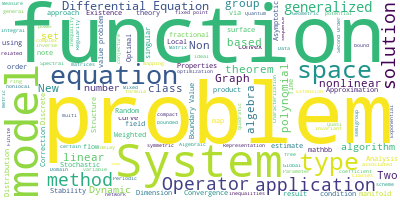

In [5]:
import pandas as pd
df = pd.read_csv('df_abstract.csv')
            
        
from wordcloud import WordCloud
list_ = []
for i in range(len(df)):
    list_.append(df['title'][i])
text = ' '.join(list_)
#long_string = ','.join(list(df['abstract'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(text)
# Visualize the word cloud
wordcloud.to_image()

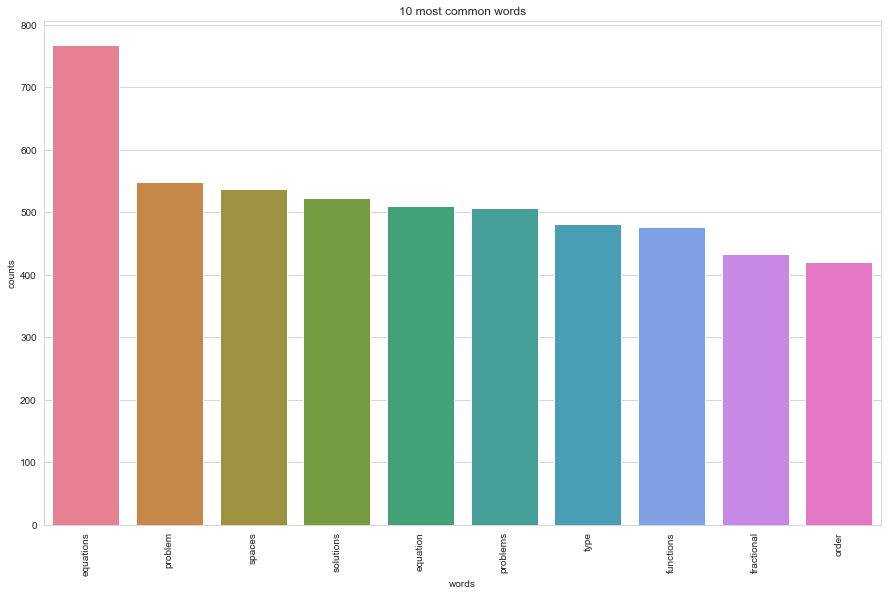

In [7]:

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
#%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
df['title'].dropna()
count_data = count_vectorizer.fit_transform(df['title'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

**Conclusion**
+ Without uing LDA and LSI Model, our top 10 common words are Equations, Problem, Spaces, Solutions, Type,  Function,Factorial,Order...
+ The above words could not show the ability to differentiate any topics. Therefore, the further methods like LDA and LSI are necessary

**Latent Dirichlet Allocation (LDA)**
+ Train LDA Model and print out the results.
+ Define functions for visualizing results.

In [7]:
# Train LDA model
lda_model = LdaMulticore(corpus = corp,
                         id2word = dct,
                         random_state = 100,
                         num_topics = 8,
                         passes = 10,
                         chunksize = 1000,
                         batch = False,
                         alpha = 'asymmetric',
                         decay = 0.5,
                         offset = 64,
                         eta = None,
                         eval_every = 0,
                         iterations = 100,
                         gamma_threshold = 0.001,
                         per_word_topics = True)

In [9]:
# Define functions for visulization
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


def sentences_chart(lda_model, corpus, start = 0, end = 8):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(15, (end-start)*0.95))       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=14, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.10
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 8:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .012 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

In [10]:
df_topic_sents_keywords = format_topics_sentences(lda_model, corp, documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7116,"algorithm, time, approach, linear, condition, ...","[book, assumed, plant, objective, carry, analy..."
1,1,0.0,0.8638,"algorithm, time, approach, linear, condition, ...","[historical, treatise, pursued, search, rule, ..."
2,2,0.0,0.4933,"algorithm, time, approach, linear, condition, ...","[empirically, test, assertion, efficacy_debrie..."
3,3,0.0,0.9914,"algorithm, time, approach, linear, condition, ...","[give, self_contained, presentation, coherent,..."
4,4,0.0,0.6719,"algorithm, time, approach, linear, condition, ...","[treatise, deal, occurrence, locally, separate..."
5,5,0.0,0.9808,"algorithm, time, approach, linear, condition, ...","[differential, constitute, powerful, mathemati..."
6,6,6.0,0.4999,"polynomial, identity, matrix, structure, sever...","[summarizes, collaboration, amodio, conservato..."
7,7,0.0,0.8124,"algorithm, time, approach, linear, condition, ...","[due, climate, change, woodland, endangered, f..."
8,8,1.0,0.9931,"ring, shape, investigate, data, polynomial, cu...","[beginning, geomagnetic_chart, interesting, ma..."
9,9,0.0,0.8305,"algorithm, time, approach, linear, condition, ...","[extremely, useful_tool, viewpoint, random_wal..."


### Results from LDA Model
+ Distribution of Document Processed Word Counts

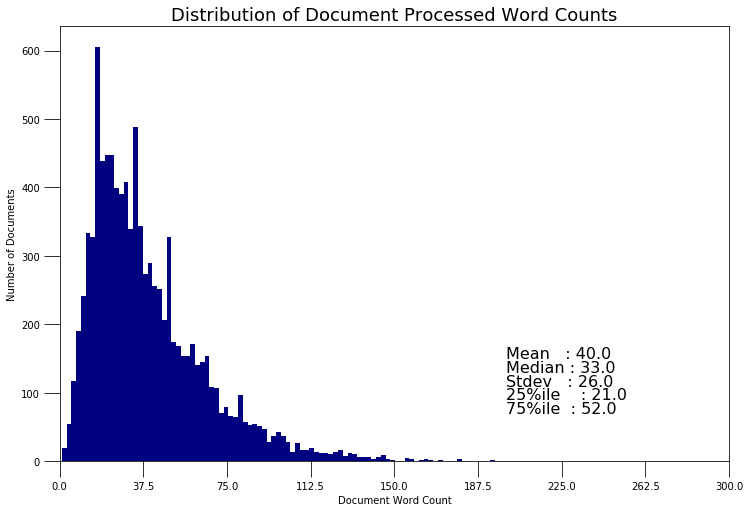

In [12]:
# Plot 1
doc_lens = [len(d) for d in df_dominant_topic.Text if len(d) > 0]
    
# Plot 1
plt.figure(figsize=(12,8))

plt.hist(doc_lens, bins = 150, color='navy')
plt.text(200, 150, "Mean   : " + str(round(np.mean(doc_lens))), size=16)
plt.text(200,  130, "Median : " + str(round(np.median(doc_lens))), size=16)
plt.text(200,  110, "Stdev   : " + str(round(np.std(doc_lens))), size=16)
plt.text(200,  90, "25%ile    : " + str(round(np.quantile(doc_lens, q=0.25))), size=16)
plt.text(200,  70, "75%ile  : " + str(round(np.quantile(doc_lens, q=0.75))), size=16)

plt.gca().set(xlim=(0, 300), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,300,9))
plt.title('Distribution of Document Processed Word Counts', fontdict=dict(size=18))
plt.show()

+ Distribution of Document Word Counts by Dominant Topic

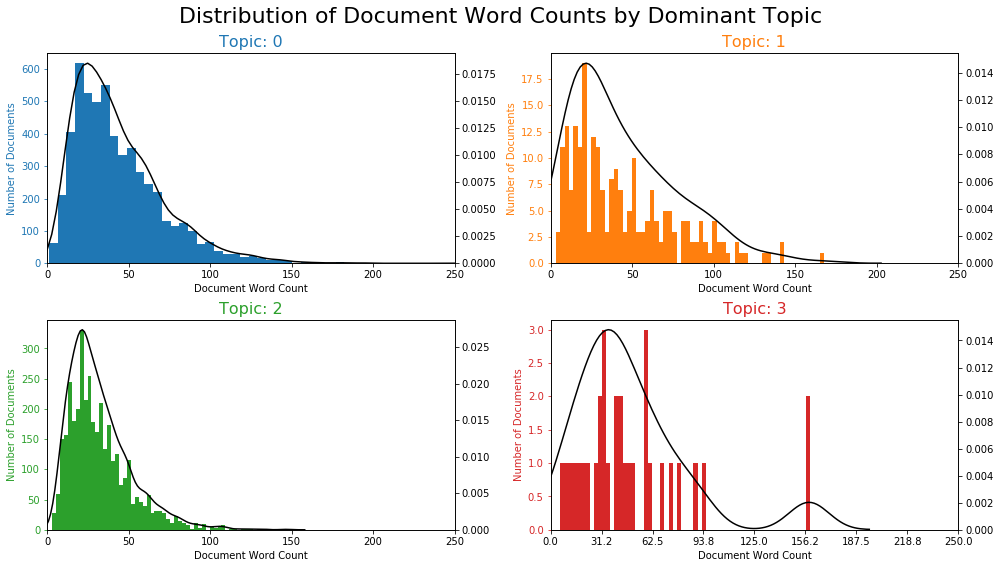

In [14]:
# Plot 2
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(14,8), sharex=False, sharey=False)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text if len(d) > 0]
    ax.hist(doc_lens, bins = 60, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 250), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,250,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

+ Word Clouds of 8 Topics Built from LDA Model

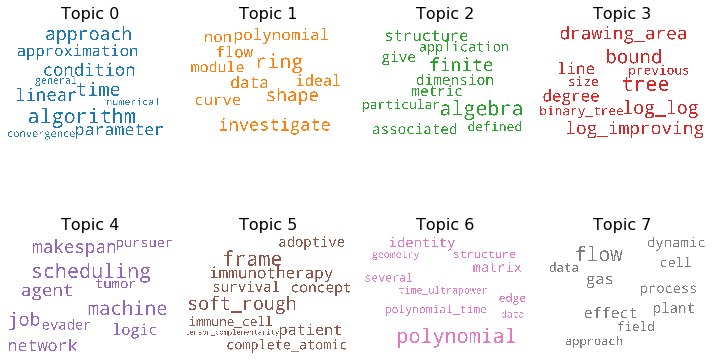

In [15]:
# Plot 3
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(10,7), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

+ Keywords’ Count and Importance Weights of Top 4 Topics

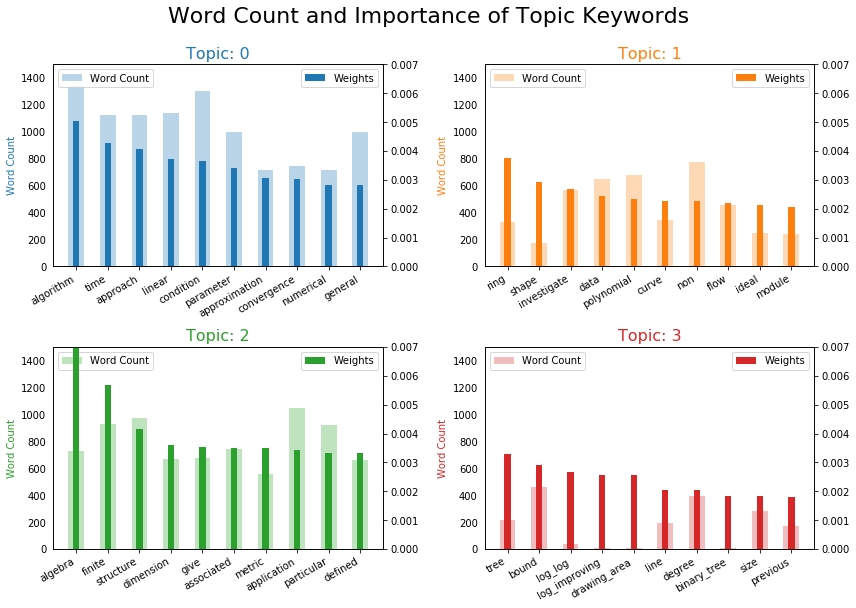

In [16]:
# Plot 4
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in documents for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(12,8))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], 
           width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], 
                width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.007); ax.set_ylim(0, 1500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

+ Word Coloring by Topic Samples

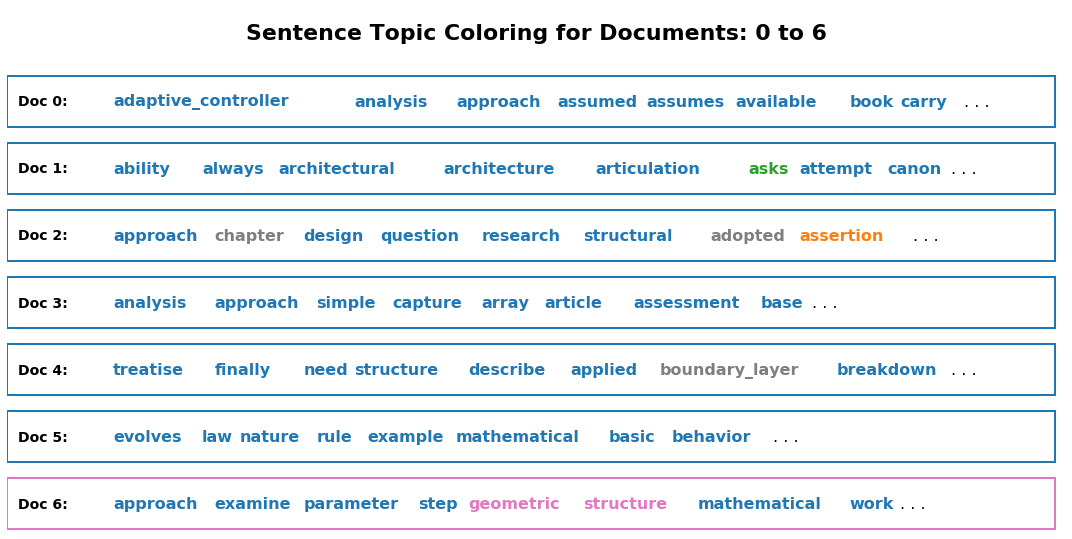

In [17]:
# Plot 5
# Sentence Coloring of N Sentences

sentences_chart(lda_model,corp)    
    

+ t-SNE Clustering of LDA Topics

In [18]:
# Plot 6
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corp]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
output_file("foo.html")
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9760 samples in 0.008s...
[t-SNE] Computed neighbors for 9760 samples in 0.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9760
[t-SNE] Computed conditional probabilities for sample 2000 / 9760
[t-SNE] Computed conditional probabilities for sample 3000 / 9760
[t-SNE] Computed conditional probabilities for sample 4000 / 9760
[t-SNE] Computed conditional probabilities for sample 5000 / 9760
[t-SNE] Computed conditional probabilities for sample 6000 / 9760
[t-SNE] Computed conditional probabilities for sample 7000 / 9760
[t-SNE] Computed conditional probabilities for sample 8000 / 9760
[t-SNE] Computed conditional probabilities for sample 9000 / 9760
[t-SNE] Computed conditional probabilities for sample 9760 / 9760
[t-SNE] Mean sigma: 0.000053
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.880676
[t-SNE] KL divergence after 1000 iterations: 0.529630


Loading BokehJS ...

### Analysis
+ Latent Dirichlet Allocation (LDA) model is useful to perform topic modelling task on abstracts of academic articles and papers.
+ By tuning LDA model and ameliorate data preprocessing workflow, different math-related keywords are gathered into different topics: linear algorithm (Topic 0), geometry (Topic 1), algebra with finite method (Topic 2), and etc.
+ Latent Semantics Indexing (LSI) helps to figure out the hidden concepts or topics behind the words. The documents are gathered into 5 different topics, 2 of which are combined manually.


### LSI Visulization
+ pie chart of count of topics
+ word clound for different topics

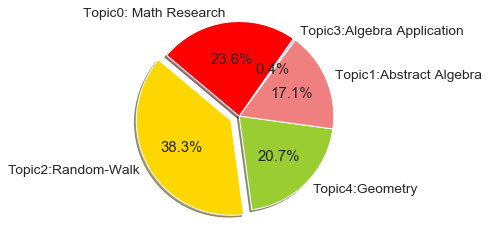

In [8]:
import pandas as pd
df = pd.read_csv('df_dominant_topic.csv')

#df1 = df[df['Sales'] >= s]
df.Dominant_Topic.value_counts()

import matplotlib.pyplot as plt

# Data to plot
labels = 'Topic2:Random-Walk', 'Topic4:Geometry', 'Topic1:Abstract Algebra', 'Topic3:Algebra Application', 'Topic0: Math Research'
sizes = [381, 206, 170, 4, 235]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue',  'red']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

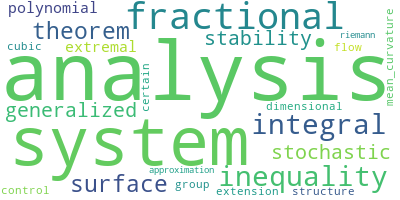

In [21]:
import pandas as pd
df = pd.read_csv('df_dominant_topic.csv')

df1 = df[df['Dominant_Topic'] == 0]
df2 = df[df['Dominant_Topic'] == 1]
df3 = df[df['Dominant_Topic'] == 2]
df4 = df[df['Dominant_Topic'] == 3]
df5 = df[df['Dominant_Topic'] == 4]
df6 = df[df['Dominant_Topic'] == 5]

from wordcloud import WordCloud

def plot_wordcloud(df, dfx):
    list_ = []
    for i in range(len(dfx)):
        list_.append(df['Keywords'][i])
    text = ' '.join(list_)

    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
    wordcloud.generate(text)
# Visualize the word cloud
    return wordcloud.to_image()
plot_wordcloud(df, df1)


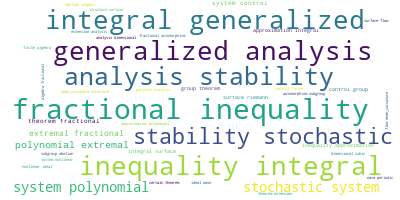

In [22]:
plot_wordcloud(df, df2)


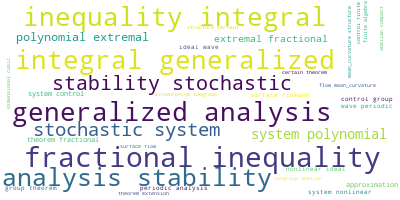

In [23]:
plot_wordcloud(df, df3)


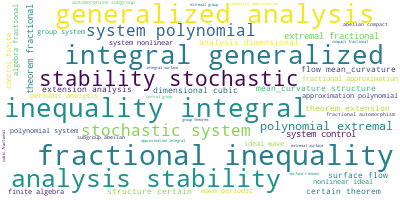

In [24]:
plot_wordcloud(df, df4)


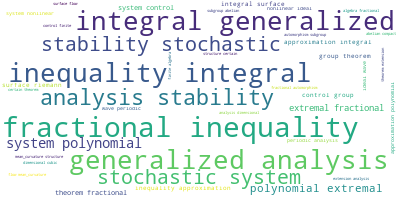

In [25]:
plot_wordcloud(df, df5)


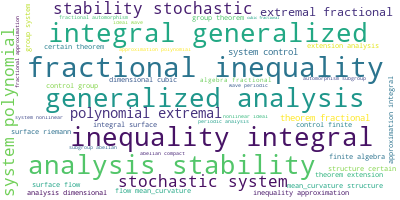

In [26]:
plot_wordcloud(df, df6)

### References
[1] R. Rubin. Foundations of Library and Information Science. 2nd ed. New York: Neal-Schuman, 2004.

[2] Michael Paul and Roxana Girju. Topic Modeling of Research Fields: An Interdisciplinary Perspective, 2009 In https://www.aclweb.org/anthology/R09-1061/

[3] Akira Murakami. Getting to know your corpus: applying Topic Modelling to corpus of research articles. University of Cambridge, 2016
